In [1]:
import hashlib
import os
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import urllib.request
import numpy as np
import pandas as pd

In [12]:
pan_dulce_types = {'conchita': ['conchita', 'concha'],
                    'quequito': ['quequito',
                    'mantecada',
                    'mantecada de chocolate',
                    'quequito de chocolate'],
                    'puerquito': ['puerquito', 'cochinito', 'marranito', 'puerco'],
                    'barquillo': ['barquillo', 'cono de crema'],
                    'orejas': ['orejas', 'orejitas'],
                    'pan-de-muerto': ['pan de muerto'],
                    'rosca-de-reyes': ['rosca de reyes'],
                    'donas': ['donas'],
                    'cuernitos': ['cuernitos', 'cuerno'],
                    'besos': ['besos', 'besitos', 'ojo de buey', 'yoyos']}

In [5]:
subscription_key = input('Enter your subscription key: ')
search_url = "https://api.bing.microsoft.com/v7.0/images/search"
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

In [ ]:
for pan, names in pan_dulce_types.items():
    directory = 'dataset/' + pan
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    queries = [name + ' pan dulce' for name in names]
    for n, query in enumerate(queries):
        nimages = 5 - len(queries)
        for i in range(nimages):
            params  = {'q': query, 'count': 50, 'offset': i * 50}
            response = requests.get(search_url, headers=headers, params=params)
            response.raise_for_status()
            search_results = response.json()
            thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"]]
            for j, url in enumerate(thumbnail_urls):
                try:
                    urllib.request.urlretrieve(url, directory + '/' + pan + '-'+ str(j + i * 150 + n*300) + ".jpg")
                except:
                    pass

    hashes = set()
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        digest = hashlib.sha1(open(path,'rb').read()).digest()
        if digest not in hashes:
            hashes.add(digest)
            os.rename(path, directory + '/' + filename)
        else:
            os.remove(path)

In [84]:
# Code to rename all images in a directory
directory = 'dataset'
df = pd.DataFrame(columns=['filename', 'label'])
# Convert labels to integers with dictionary
labels = {}

for i, folder in enumerate(os.listdir(directory)):
    labels[folder] = i
    if folder != 'test':
        for j, filename in enumerate(os.listdir(directory + '/' + folder)):
            os.rename(directory + '/' + folder + '/' + filename, directory + '/' + folder + '/' + folder + '_' + str(j) + '.jpg')
            df = pd.concat([df, pd.DataFrame({'filename': folder + '/' + folder + '_' + str(j) + '.jpg', 'label': labels[folder]}, index = [0])], axis=0)

df.to_csv('pan_dulce.csv', index=False)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import PIL
from pan_dulce_dataset import PanDulceDataset
from sklearn.model_selection import train_test_split
from skimage import io

In [212]:
means = [0.485, 0.456, 0.406]
stdvs = [0.229, 0.224, 0.225]

image_transforms = { 
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256), 
        transforms.RandomCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means,
                             stdvs)
    ]),
    'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(means,
                                     stdvs)])}

train_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['train'])

test_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

val_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

classes = ('barquillo', 'besos', 'conchita', 'cuernitos',
            'donas', 'orejas', 'pan-de-muerto',
            'puerquito', 'quequito', 'rosca-de-reyes')

In [213]:
num_train = len(train_dataset)
indices = list(range(num_train))
labels = pd.read_csv('pan_dulce.csv')['label'].values

train_indices, test_indices, train_labels, _ = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=42)
train_indices, val_indices= train_test_split(train_indices, test_size=0.2,stratify = train_labels, random_state=42)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f'Train size: {len(train_loader.dataset)}')
print(f'Validation size: {len(val_loader.dataset)}')
print(f'Test size: {len(test_loader.dataset)}')

Train size: 1045
Validation size: 262
Test size: 327


In [87]:
# Count number of images per class in train, validation and test
train_count = [0] * 10
val_count = [0] * 10
test_count = [0] * 10

for i in range(len(train_loader.dataset)):
    train_count[train_loader.dataset[i][1]] += 1

for i in range(len(val_loader.dataset)):
    val_count[val_loader.dataset[i][1]] += 1

for i in range(len(test_loader.dataset)):
    test_count[test_loader.dataset[i][1]] += 1

print(f'Train count: {train_count}')
print(f'Validation count: {val_count}')
print(f'Test count: {test_count}')

Train count: [45, 74, 203, 81, 76, 103, 173, 98, 79, 113]
Validation count: [11, 19, 51, 20, 19, 26, 43, 24, 20, 29]
Test count: [14, 23, 64, 25, 23, 32, 54, 31, 25, 36]


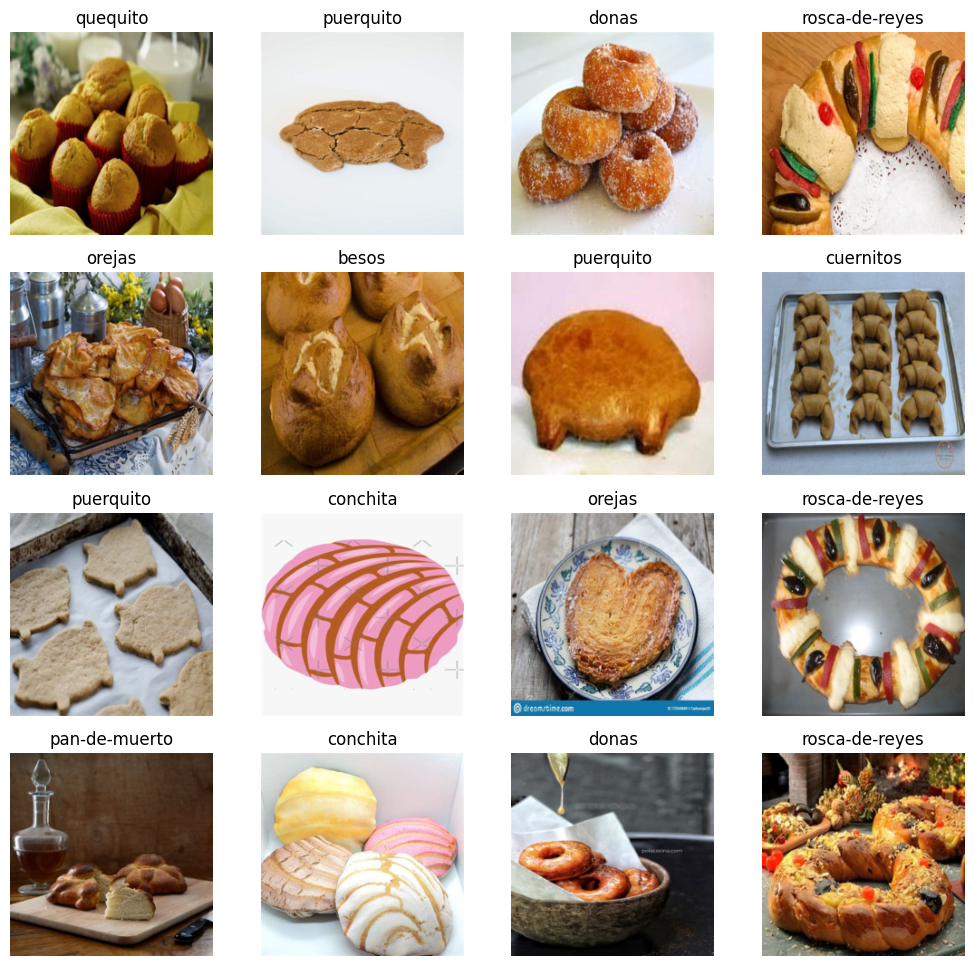

In [190]:
# view some images in training set
import matplotlib.pyplot as plt
import numpy as np

batch_X, batch_Y =  next(iter(test_loader))

plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.tight_layout()
        img_r = batch_X[i*4+j][0] * stdvs[0] + means[0]
        img_g = batch_X[i*4+j][1] * stdvs[1] + means[1]
        img_b = batch_X[i*4+j][2] * stdvs[2] + means[2]
        img = torch.stack([img_r, img_g, img_b])
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(classes[batch_Y[i*4+j]])
        plt.axis('off')
plt.show()

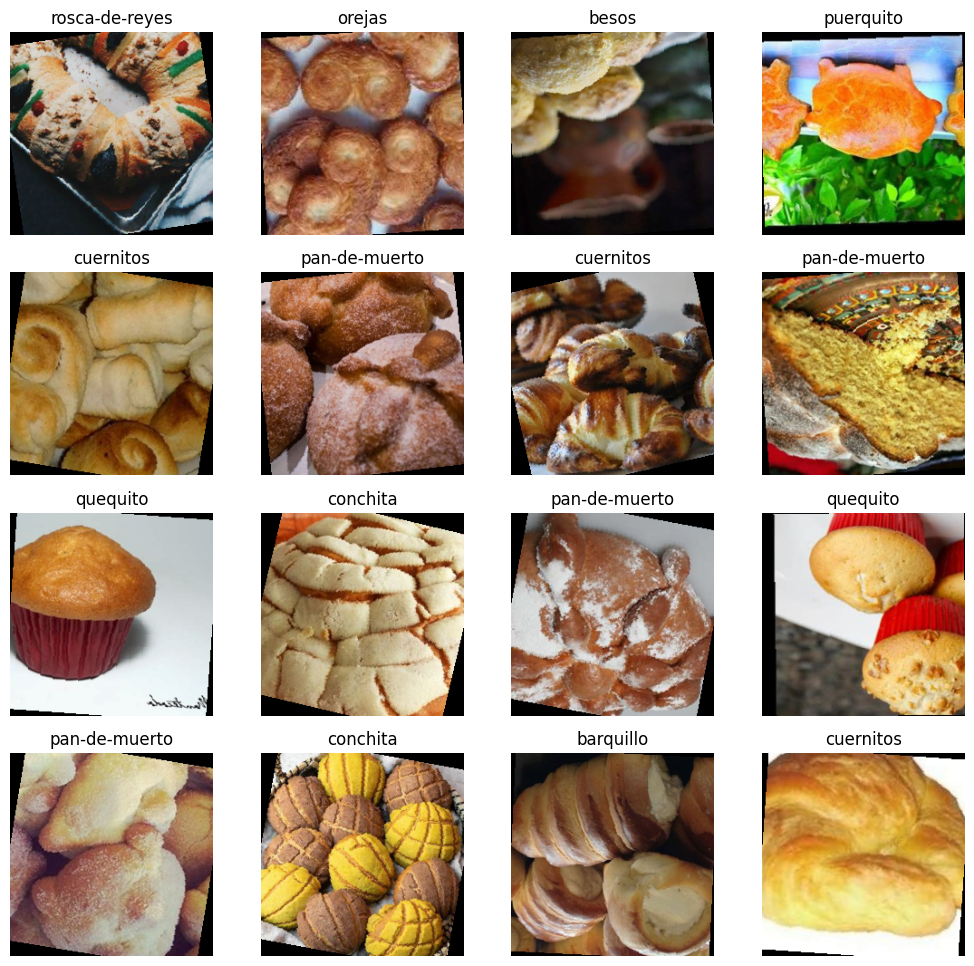

In [185]:
batch_X, batch_Y =  next(iter(train_loader))

plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.tight_layout()
        img_r = batch_X[i*4+j][0] * stdvs[0] + means[0]
        img_g = batch_X[i*4+j][1] * stdvs[1] + means[1]
        img_b = batch_X[i*4+j][2] * stdvs[2] + means[2]
        img = torch.stack([img_r, img_g, img_b])
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(classes[batch_Y[i*4+j]])
        plt.axis('off')
plt.show()

In [216]:
# Define the model
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

model = torchvision.models.resnet50(weights = 'DEFAULT')
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(p = 0.3),
                         nn.Linear(512, 10),                    
                         nn.LogSoftmax(dim=1))

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [217]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
# Define training loop:
import time
def fit(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cpu'):
    start = time.time()
    print(f'Running training loop on {device}')
    history = []
    best_acc = 0.0
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f'Epoch: {epoch + 1}/{epochs}')
        model.train()

        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
            print(f'Batch: {i+1}/{len(train_loader)}', end='\r')
        
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                val_acc += acc.item() * inputs.size(0)
        
        avg_train_loss = train_loss/len(train_loader.dataset)
        avg_train_acc = train_acc/len(train_loader.dataset)
        avg_val_loss = val_loss/len(val_loader.dataset)
        avg_val_acc = val_acc/len(val_loader.dataset)
        history.append([avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])
        print(f'train loss: {avg_train_loss:.4f}, train acc: {avg_train_acc:.4f}, val loss: {avg_val_loss:.4f}, val acc: {avg_val_acc:.4f}, time: {time.time() - epoch_start:.2f}s')

        if avg_val_acc >= best_acc:
            best_acc = avg_val_acc
            torch.save(model.state_dict(), 'best_checkpoint.model')
    print(f'Finished training in {time.time() - start:.2f}s. \nBest val acc: {best_acc:.4f}')
    return model, history

In [218]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
trained_model, history = fit(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Running training loop on cpu
Epoch: 1/15
train loss: 1.6638, train acc: 0.4919, val loss: 1.0211, val acc: 0.7939, time: 359.34s
Epoch: 2/15
train loss: 0.7854, train acc: 0.7847, val loss: 0.6298, val acc: 0.8397, time: 338.44s
Epoch: 3/15
train loss: 0.5178, train acc: 0.8507, val loss: 0.5869, val acc: 0.8282, time: 327.22s
Epoch: 4/15
train loss: 0.3814, train acc: 0.8900, val loss: 0.5084, val acc: 0.8702, time: 328.38s
Epoch: 5/15
train loss: 0.3115, train acc: 0.9129, val loss: 0.4516, val acc: 0.8817, time: 328.60s
Epoch: 6/15
train loss: 0.2571, train acc: 0.9321, val loss: 0.4616, val acc: 0.8588, time: 324.66s
Epoch: 7/15
train loss: 0.2782, train acc: 0.9139, val loss: 0.4106, val acc: 0.8893, time: 323.31s
Epoch: 8/15
train loss: 0.2045, train acc: 0.9455, val loss: 0.4447, val acc: 0.8855, time: 322.65s
Epoch: 9/15
train loss: 0.1948, train acc: 0.9502, val loss: 0.3902, val acc: 0.8931, time: 381.94s
Epoch: 10/15
train loss: 0.1800, train acc: 0.9464, val loss: 0.4266, v

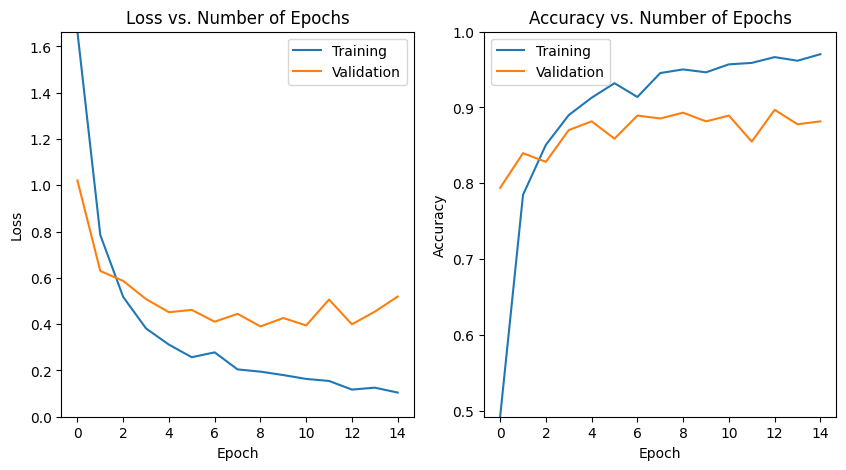

In [220]:
#Plot performance over time
history = np.array(history)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history[:, 0:2])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Epochs')
plt.ylim(0, max(history[:, 0]))
plt.subplot(1, 2, 2)
plt.plot(history[:, 2:4])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.ylim(min(history[:, 2]), 1)
plt.show()

In [225]:
# Load best checkpoint
trained_model.load_state_dict(torch.load('best_checkpoint.model'))

<All keys matched successfully>

In [227]:
# Make predictions
def predict(model, test_loader, device='cpu'):
    predictions = []
    real_values = []
    with torch.no_grad():
        model.eval()
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    return predictions, real_values

In [240]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

predictions, real_values = predict(model, test_loader, device)
predictions = torch.stack(predictions).cpu()
real_values = torch.stack(real_values).cpu()
print(f'Accuracy: {accuracy_score(real_values, predictions):.4f} or {accuracy_score(real_values, predictions)*100:.2f}%')
print(f'Precision: {precision_score(real_values, predictions, average="weighted"):.4f} or {precision_score(real_values, predictions, average="weighted")*100:.2f}%')
print(f'Recall: {recall_score(real_values, predictions, average="weighted"):.4f} or {recall_score(real_values, predictions, average="weighted")*100:.2f}%')
print(f'F1: {f1_score(real_values, predictions, average="weighted"):.4f} or {f1_score(real_values, predictions, average="weighted")*100:.2f}%')
print('Classification report: \n', classification_report(real_values, predictions))

Accuracy: 0.8899 or 88.99%
Precision: 0.8955 or 89.55%
Recall: 0.8899 or 88.99%
F1: 0.8892 or 88.92%
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.94      0.70      0.80        23
           2       0.89      0.91      0.90        64
           3       0.83      0.80      0.82        25
           4       0.79      0.96      0.86        23
           5       0.83      0.94      0.88        32
           6       0.85      0.94      0.89        54
           7       1.00      0.97      0.98        31
           8       1.00      0.88      0.94        25
           9       0.94      0.89      0.91        36

    accuracy                           0.89       327
   macro avg       0.90      0.87      0.88       327
weighted avg       0.90      0.89      0.89       327



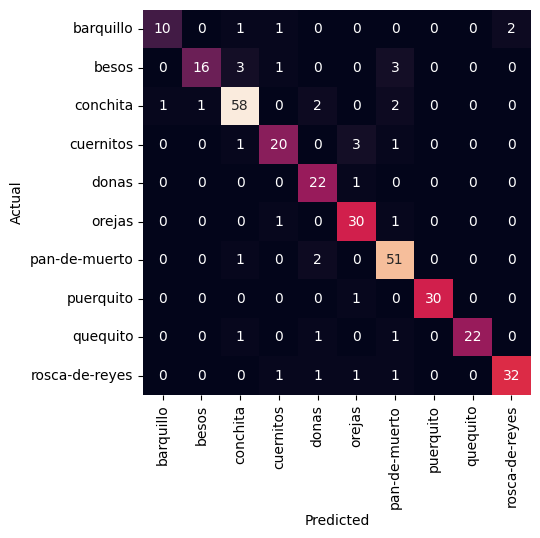

In [229]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions, real_values = predict(trained_model, test_loader, device)
cm = confusion_matrix(real_values, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(10) + 0.5, classes, rotation=90)
plt.yticks(np.arange(10) + 0.5, classes, rotation=0)
plt.show()

In [230]:
real_dataset = torch.tensor([])
for file in os.listdir('dataset/test/'):
    img = io.imread('dataset/test/'+file)
    img = image_transforms['test'](img)
    real_dataset = torch.cat((real_dataset, img.unsqueeze(0)), 0)

In [231]:
outputs = trained_model(real_dataset)
output_labels = torch.max(outputs.data, 1)
output_classes = [classes[i] for i in output_labels[1].tolist()]

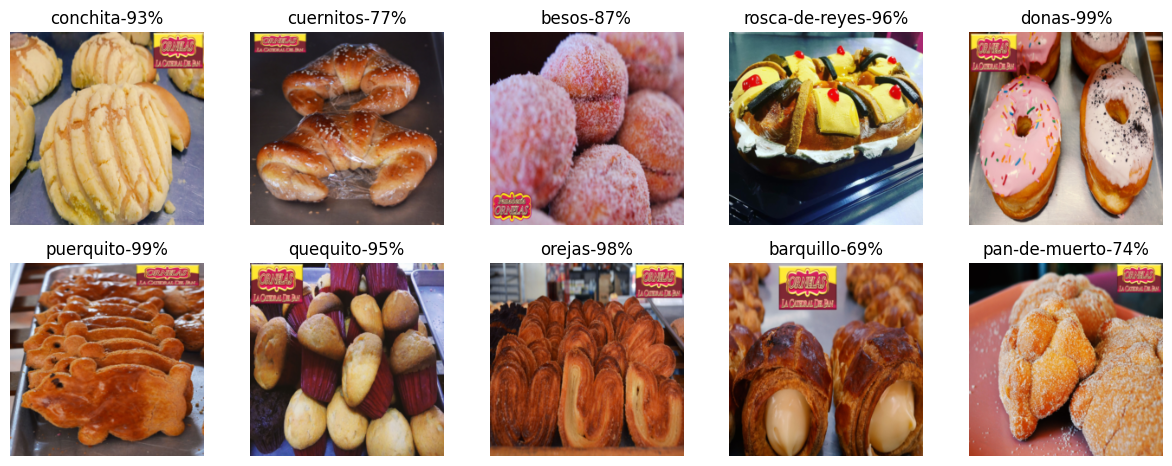

In [236]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.tight_layout()
    img_r = real_dataset[i][0] * stdvs[0] + means[0]
    img_g = real_dataset[i][1] * stdvs[1] + means[1]
    img_b = real_dataset[i][2] * stdvs[2] + means[2]
    img = torch.stack([img_r, img_g, img_b])
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(output_classes[i] + '-' + str(int(np.exp(output_labels[0][i].item()) * 100)) + '%')
    plt.axis('off')

In [237]:
torch.save(trained_model, 'pan_dulce_model.pt')

In [239]:
loaded_model = torch.load('pan_dulce_model.pt')
summary(loaded_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,